# Chapter 2. End-to-End Machine Learning Project

In this chapter you will work through an example project end to end,
pretending to be a recently hired data scientist at a real estate company.
Here are the main steps we will walk through:
1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data to gain insights.
4. Prepare the data for machine learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.

# Look at the Big Picture

Welcome to the Machine Learning Housing Corporation! Your first task is
to use California census data to build a model of housing prices in the
state. 

This data includes metrics such as the population, median income,
and median housing price for each block group in California. Block groups
are the smallest geographical unit for which the US Census Bureau
publishes sample data (a block group typically has a population of 600 to
3,000 people). I will call them “districts” for short.

Your model should learn from this data and be able to predict the median
housing price in any district, given all the other metrics.

# Select a Performance Measure

A typical performance measure for regression problems is the root mean square error (RMSE). 
It gives an idea of how much error the system typically makes in its
predictions, with a higher weight given to large errors.

$\text{RMSE}(X,h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}\left(h\left(\mathbb{x}^{(i)}-y^{(i)})^2 \right)\right)}$

# Get the Data

In [2]:
# import some libraries to work with 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

housing = pd.read_csv("https://raw.githubusercontent.com/thomouvic/SENG474/main/data/housing.csv")

# Take a Quick Look at the Data Structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. 
There are 10 attributes: 
`longitude`, `latitude`, `housing_median_age`, `total_rooms`, `total_bedrooms`,
`population`, `households`, `median_income`, `median_house_value`,
and `ocean_proximity`.

**Note.** `total_rooms` is the total number of rooms over all households of a district. If you want the average for household, divide `total_rooms` by `households`. Same for `total_bedrooms`. 
There is a similar dataset as part of scikit-learn: `sklearn.datasets.fetch_california_housing` (average number of bedroom is given). See also: https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

In [3]:
# Average number of rooms for the first district.

880/126

6.984126984126984

The `info()` method is useful to get a quick description of the data, in
particular the total number of rows, each attribute’s type, and the number
of non-null values:

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset. 
You notice that the total_bedrooms attribute has only 20,433 non-null
values, meaning that 207 districts are missing this feature. You will need to
take care of this later.

All attributes are numerical, except for `ocean_proximity`. Its type is
object, so it could hold any kind of Python object. But since you loaded
this data from a CSV file, you know that it must be a text attribute. 

When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is
probably a categorical attribute. You can find out what categories exist and
how many districts belong to each category by using the
`value_counts()` method:

In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Let’s look at the other fields. The describe() method shows a summary
of the numerical attributes.

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


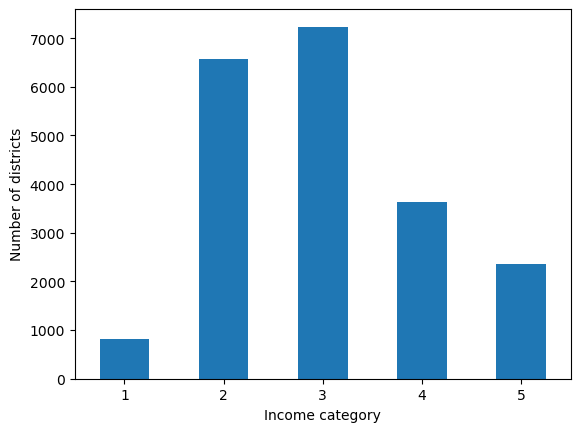

In [7]:
# create a new attribute income_cat using pd.cut()
# the attribute has 5 categories: 1, 2, 3, 4, 5

housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6.,np.inf],
                               labels=[1, 2, 3, 4, 5])

# show the bar plot of income_cat
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


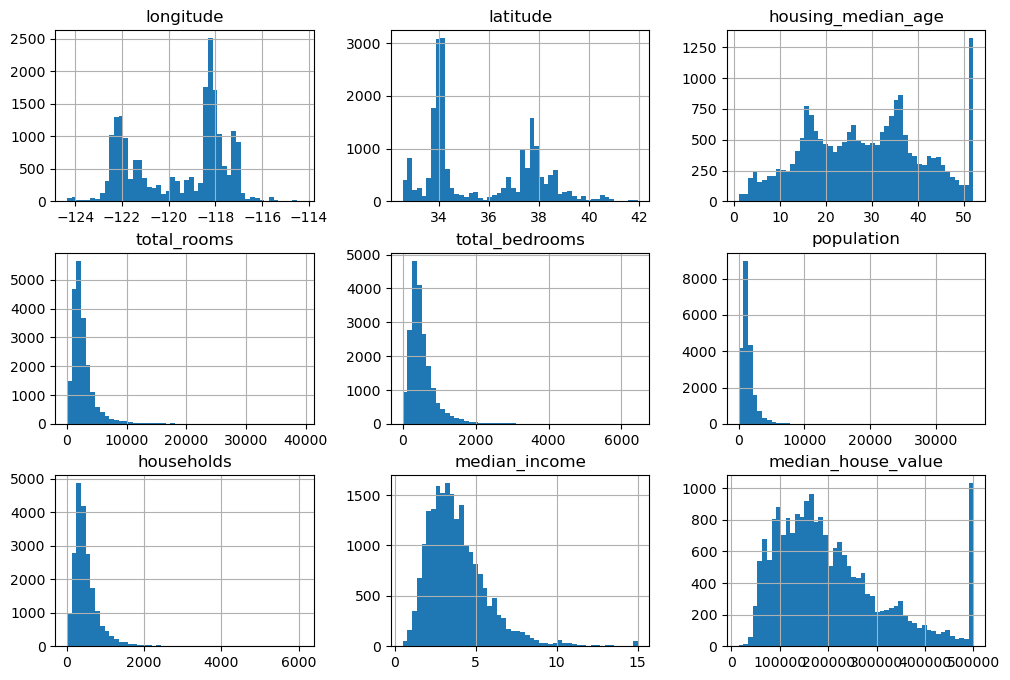

In [8]:
# show histogram of the numerical attributes
housing.hist(bins=50, figsize=(12, 8))
plt.show()

Looking at these histograms, you notice a few things:

* First, the median income attribute does not look like it is expressed in
US dollars (USD). After checking with the team that collected the
data, you are told that the data has been scaled and capped at 15
for higher median incomes, and at 0.5 for lower median incomes. 
The numbers represent roughly
tens-of-thousands of dollars (e.g., 3 actually means about \$30,000).
Working with preprocessed attributes is common in machine learning,
and it is not necessarily a problem, but you should try to understand
how the data was computed.

* The housing median age and the median house value were also
capped. The latter may be a serious problem since it is your target
attribute (your labels). Your machine learning algorithms may learn
that prices never go beyond that limit. 

* These attributes have very different scales. We will discuss this later
in this chapter, when we explore feature scaling.

You should now have a better understanding of the kind of data you’re
dealing with.

## Create a Test Set

It may seem strange to voluntarily set aside part of the data at this stage.
After all, you have only taken a quick glance at the data, and surely you
should learn a whole lot more about it before you decide what algorithms
to use, right? This is true, but your brain is an amazing pattern detection
system, which also means that it is highly prone to overfitting: if you look
at the test set, you may stumble upon some seemingly interesting pattern
in the test data that leads you to select a particular kind of machine
learning model. When you estimate the generalization error using the test
set, your estimate will be too optimistic, and you will launch a system that
will not perform as well as expected. This is called data snooping bias.
Creating a test set is theoretically simple; pick some instances randomly,
typically 20% of the dataset (or less if your dataset is very large), and set
them aside:

In [9]:
import numpy as np
# write a function to split the data into training and test sets
# the function takes the data and the test ratio as input 
# it returns the training tand test sets

def shuffle_and_split_data(data, test_ratio):
  # set the random seed to 42
  np.random.seed(42) # so that we generate the same random numbers always
  # shuffle the indicies
  shuffled_indices = np.random.permutation(len(data))
  # calculate the number of test instances
  test_set_size = int(len(data)*test_ratio)
  # get the indices of the test instances
  test_indices = shuffled_indices[:test_set_size]
  # get the indices of the training instances
  train_indices = shuffled_indices[test_set_size:]
  # return the training and test sets
  return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
# call the function to split the data into training and test sets
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [11]:
# Another way using sklearn method
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

*italicized text*# Stratified sampling

So far we have considered purely random sampling methods. This is
generally fine if your dataset is large enough (especially relative to the
number of attributes), but if it is not, you run the risk of introducing a
significant sampling bias. 

When employees at a survey company decides
to call 1,000 people to ask them a few questions, they don’t just pick 1,000
people randomly in a phone book. They try to ensure that these 1,000
people are representative of the whole population, with regard to the
questions they want to ask. 

For example, the US population is 51.1%
females and 48.9% males, so a well-conducted survey in the US would try
to maintain this ratio in the sample: 511 females and 489 males. 

This is called **stratified sampling**: the population is divided into homogeneous
subgroups called strata, and the right number of instances are sampled
from each stratum to guarantee that the test set is representative of the
overall population. 

Suppose you’ve chatted with some experts who told you that the median
income is a very important attribute to predict median housing prices. You
may want to ensure that the test set is representative of the various
categories of incomes in the whole dataset. 

Since the median income is a
continuous numerical attribute, you first need to create an income
category attribute. Let’s look at the median income histogram more closely: most median income values are clustered around 1.5
to 6 (i.e., \$15,000–\$60,000), but some median incomes go far beyond 6. 

It is important to have a sufficient number of instances in your dataset for
each stratum, or else the estimate of a stratum’s importance may be
biased. This means that you should not have too many strata, and each
stratum should be large enough. The following code uses the `pd.cut()`
function to create an income category attribute with five categories
(labeled from 1 to 5); category 1 ranges from 0 to 1.5 (i.e., less than
\$15,000), category 2 from 1.5 to 3, and so on:

In [12]:
# do stratified sampling based on income_cat
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, 
                                                   stratify=housing["income_cat"],
                                                   random_state=42)
len(train_set), len(test_set)

(16512, 4128)

In [13]:
# obtain a train and test set without using the stratified sampling
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set), len(test_set)

(16512, 4128)

In [14]:
# check the propertions of income_cat in the test set obtained
# usign stratified sampling and without stratifies sampling
print(housing["income_cat"].value_counts() / len(housing))
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print(test_set["income_cat"].value_counts() / len(test_set))

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64
income_cat
3    0.345203
2    0.307413
4    0.184109
5    0.120882
1    0.042393
Name: count, dtype: float64


What do you observe from these numbers?

As you can see, the test
set generated using stratified sampling has income category proportions
almost identical to those in the full dataset, whereas the test set generated
using purely random sampling is skewed.

In [15]:
# Drop income_cat column. We won't be needing it anymore. 
strat_test_set.drop("income_cat", axis=1, inplace=True)
strat_train_set.drop("income_cat", axis=1, inplace=True)

# Explore and Visualize the Data to Gain Insights

So far you have only taken a quick glance at the data to get a general
understanding of the kind of data you are manipulating. Now the goal is to
go into a little more depth.

First, make sure you have put the test set aside and you are only
exploring the training set.

In [16]:
# create a copy of the training set
housing = strat_train_set.copy()

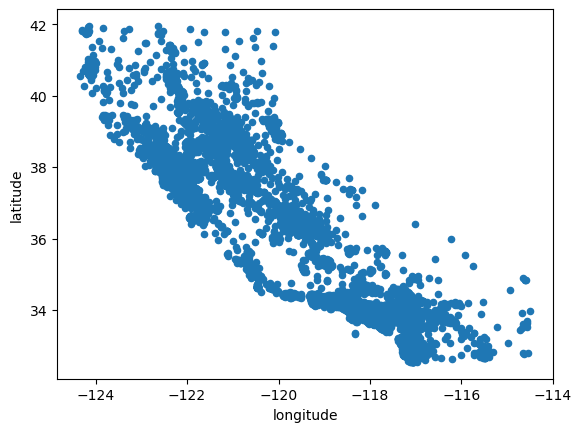

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

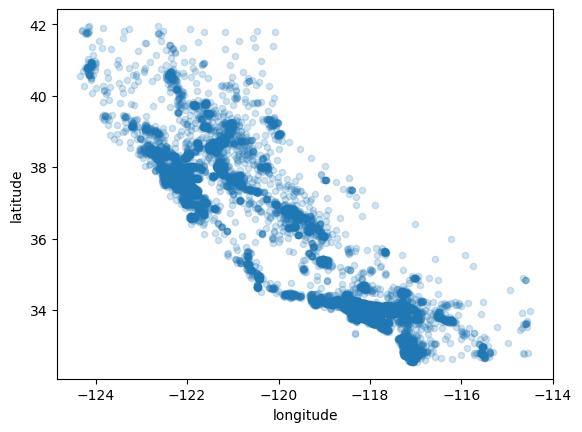

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2)
plt.show()

This looks like California all right, but other than that it is hard to see any
particular pattern. Setting the alpha option to 0.2 makes it much easier
to visualize the places where there is a high density of data points

Next, we look at the housing prices. The radius of each
circle represents the district’s population (option s), and the color
represents the price (option c).

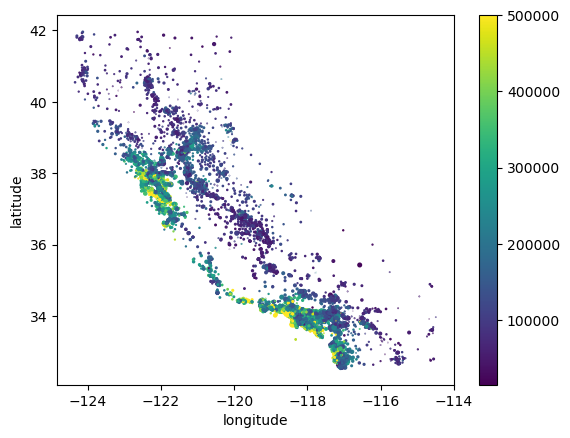

In [19]:
housing.plot(kind='scatter', x='longitude', y='latitude',  
             s=housing['population']/1000,
             c=housing['median_house_value'], 
             colorbar=True)
plt.show()

This image tells you that the housing prices are very much related to the
location (e.g., close to the ocean) and to the population density, as you
probably expected already.

### Look for Correlations

Since the dataset is not too large, you can easily compute the standard
correlation coefficient (also called Pearson’s r) between every pair of
attributes using the corr() method:

In [20]:
# select numerical attributes
housing_num = housing.select_dtypes(include=[np.number])

corr_matrix =housing_num.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


The correlation coefficient ranges from –1 to 1. When it is close to 1, it
means that there is a strong positive correlation; for example, the median
house value tends to go up when the median income goes up. When the
coefficient is close to –1, it means that there is a strong negative
correlation; you can see a small negative correlation between the latitude
and the median house value (i.e., prices have a slight tendency to go
down when you go north). Finally, coefficients close to 0 mean that there is
no linear correlation.

Another way to check for correlation between attributes is to use the
Pandas `scatter_matrix()` function, which plots every numerical
attribute against every other numerical attribute. Since there are now 11
numerical attributes, you would get 11 = 121 plots, which would not fit on
a page—so you decide to focus on a few promising attributes that seem
most correlated with the median housing value:

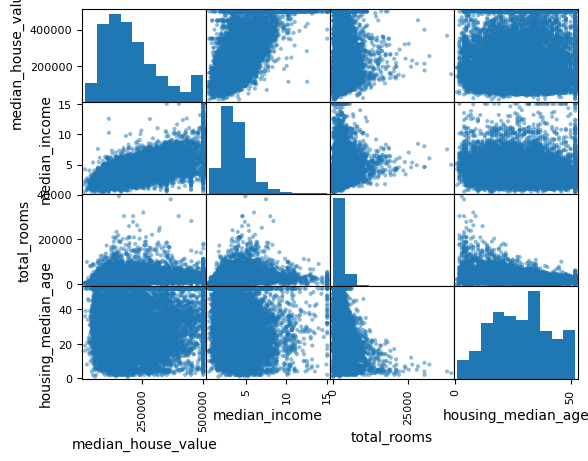

In [21]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 
              'median_income', 
              'total_rooms', 
              'housing_median_age']

scatter_matrix(housing[attributes])
plt.show()

The main diagonal would be full of straight lines if Pandas plotted each
variable against itself, which would not be very useful. So instead, the
Pandas displays a histogram of each attribute.

Looking at the correlation scatterplots, it seems like the most promising
attribute to predict the median house value is the median income, so you
zoom in on their scatterplot.

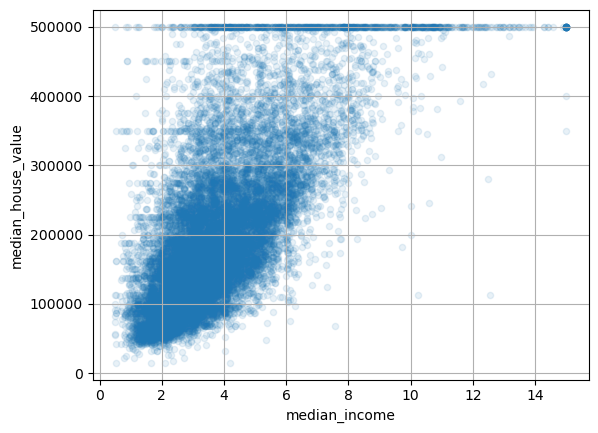

In [22]:
housing.plot(kind="scatter", 
             x="median_income",
             y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

This plot reveals a few things. First, the correlation is indeed quite strong;
you can clearly see the upward trend, and the points are not too
dispersed. Second, the price cap you noticed earlier is clearly visible as a
horizontal line at \$500,000.

**Warning.**
The correlation coefficient only measures linear correlations (“as x goes up, y
generally goes up/down”). It may completely miss out on nonlinear
relationships.

See Wikipedia article for an interesting figure https://en.wikipedia.org/wiki/Correlation. The figure shows a variety of datasets along with their correlation coefficient. 

Note how all the plots of the bottom row have a correlation coefficient equal to 0, despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships. 

Also, the second row shows examples where the correlation coefficient is equal to 1 or –1; notice that this has nothing to do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.

# Experiment with Attribute Combinations

One last thing you may want to do before preparing the data for machine
learning algorithms is to try out various attribute combinations. For
example, the total number of rooms in a district is not very useful if you
don’t know how many households there are. What you really want is the
number of rooms per household. Similarly, the total number of bedrooms
by itself is not very useful: you probably want to compare it to the number
of rooms. And the population per household also seems like an interesting
attribute combination to look at. You create these new attributes as
follows.

In [23]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [24]:
housing_num = housing.select_dtypes(include=[np.number])

corr_matrix = housing_num.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

`bedrooms_ratio` is much more correlated with `median_house_value` than the `total_rooms` or `total_bedrooms`. Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

`rooms_per_house` is also more informative than the `total_rooms` in a district. Obviously the larger the houses, the more expensive they are.

# Prepare the Data for Machine Learning Algorithms

It’s time to prepare the data for your machine learning algorithms. Instead
of doing this manually, you should write functions for this purpose, for
several good reasons:

* This will allow you to reproduce these transformations easily on any
dataset (e.g., the next time you get a fresh dataset).

* You will gradually build a library of transformation functions that you
can reuse in future projects.

* You can use these functions in your live system to transform the new
data before feeding it to your algorithms.

This will make it possible for you to easily try various transformations
and see which combination of transformations works best.

First, revert to a clean training set (by copying strat_train_set
once again). You should also separate the predictors and the labels, since
you don’t necessarily want to apply the same transformations to the
predictors and the target values (note that drop() creates a copy of the
data and does not affect strat_train_set).

We might be wondering why we did not keep the useful new attributes created as combinations of original attributes. We will add them later using pipelines. 

In [25]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Clean the Data

Most machine learning algorithms cannot work with missing features, so
you’ll need to take care of these. For example, you noticed earlier that the
total_bedrooms attribute has some missing values. You have three
options to fix this:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median,
etc.). This is called imputation.

You can accomplish these easily using the Pandas DataFrame’s
`dropna()`, `drop()`, and `fillna()` methods:


```
housing.dropna(subset=["total_bedrooms"], inplace=True)
```

```
housing.drop("total_bedrooms", axis=1)
```

```
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```


You decide to go for option 3 since it is the least destructive, but instead of
the preceding code, you will use a handy Scikit-Learn class:
`SimpleImputer`. The benefit is that it will store the median value of each
feature: this will make it possible to impute missing values not only on the
training set, but also on the validation set, the test set, and any new data
fed to the model. To use it, first you need to create a `SimpleImputer`
instance, specifying that you want to replace each attribute’s missing
values with the median of that attribute:

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

Since the median can only be computed on numerical attributes, you then
need to create a copy of the data with only the numerical attributes (this
will exclude the text attribute `ocean_proximity`):

In [27]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and
stored the result in its statistics_ instance variable. Only the
total_bedrooms attribute had missing values, but you cannot be sure
that there won’t be any missing values in new data after the system goes
live, so it is safer to apply the imputer to all the numerical attributes:

In [28]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this “trained” imputer to transform the training set by
replacing missing values with the learned medians:

In [29]:
X = imputer.transform(housing_num)
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

Missing values can also be replaced with the mean value
(`strategy="mean"`), or with the most frequent value
(`strategy="most_frequent"`), or with a constant value
(`strategy="constant", fill_value=…`). The last two strategies
support non-numerical data.

There are also more powerful imputers available in the sklearn.impute
package (both for numerical features only):
`KNNImputer` replaces each missing value with the mean of the knearest
neighbors’ values for that feature. The distance is based on all
the available features.

`IterativeImputer` trains a regression model per feature to predict the
missing values based on all the other available features. It then trains the
model again on the updated data, and repeats the process several times,
improving the models and the replacement values at each iteration.

## SCIKIT-LEARN DESIGN

**Estimators**
Any object that can estimate some parameters based on a
dataset is called an estimator (e.g., a `SimpleImputer` is an
estimator). The estimation itself is performed by the `fit()`
method, and it takes a dataset as a parameter, or two for
supervised learning algorithms—the second dataset contains
the labels. Any other parameter needed to guide the estimation
process is considered a hyperparameter (such as a
`SimpleImputer`’s strategy).


**Transformers.**
Some estimators (such as a `SimpleImputer`) can also
transform a dataset; these are called transformers. 
The transformation is performed by the
`transform()` method with the dataset to transform as a
parameter. It returns the transformed dataset. This
transformation generally relies on the learned parameters, as is
the case for a SimpleImputer. All transformers also have a
convenience method called `fit_transform()`, which is
equivalent to calling `fit()` and then `transform()`.

**Predictors.**
Finally, some estimators, given a dataset, are capable of
making predictions; they are called predictors. For example, the
LinearRegression model. 
A predictor has a `predict()` method that takes a
dataset of new instances and returns a dataset of
corresponding predictions. 

**Nonproliferation of classes.**
Datasets are represented as NumPy arrays or SciPy sparse
matrices, instead of homemade classes.

## Handling Text and Categorical Attributes

In [30]:
housing_cat = housing[['ocean_proximity']]
housing_cat

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
14207,<1H OCEAN
13105,INLAND
19301,NEAR OCEAN
19121,<1H OCEAN


It’s not arbitrary text: there are a limited number of possible values, each
of which represents a category. So this attribute is a categorical attribute.
Most machine learning algorithms prefer to work with numbers, so let’s
convert these categories from text to numbers. For this, we can use Scikit-
Learn’s `OrdinalEncoder` class:

In [31]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

print(housing_cat_encoded)
print(ordinal_encoder.categories_)

[[3.]
 [0.]
 [1.]
 ...
 [4.]
 [0.]
 [4.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


One issue with this representation is that ML algorithms will assume that
two nearby values are more similar than two distant values. This may be
fine in some cases (e.g., for ordered categories such as “bad”, “average”,
“good”, and “excellent”), but it is obviously not the case for the
ocean_proximity column (for example, categories 0 and 4 are clearly
more similar than categories 0 and 1). To fix this issue, a common solution
is to create one binary attribute per category: one attribute equal to 1
when the category is "`<1H OCEAN`" (and 0 otherwise), another attribute
equal to 1 when the category is "`INLAND`" (and 0 otherwise), and so on.
This is called one-hot encoding, because only one attribute will be equal to
1 (hot), while the others will be 0 (cold). The new attributes are sometimes
called dummy attributes. Scikit-Learn provides a `OneHotEncoder` class
to convert categorical values into one-hot vectors:

In [32]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

If you want to convert it to a (dense) NumPy array, just call the `toarray()` method:

In [33]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [34]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

Pandas has a function called `get_dummies()`, which also converts each
categorical feature into a one-hot representation, with one binary feature
per category:

In [35]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


It looks nice and simple, so why not use it instead of OneHotEncoder?
Well, the advantage of OneHotEncoder is that it remembers which
categories it was trained on. This is very important because once your
model is in production, it should be fed exactly the same features as
during training: no more, no less. Look what our trained cat_encoder
outputs when we make it transform the same df_test (using
transform(), not fit_transform()):

In [36]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

See the difference? `get_dummies()` saw only two categories, so it
output two columns, whereas OneHotEncoder output one column per
learned category, in the right order. Moreover, if you feed
get_dummies() a DataFrame containing an unknown category (e.g., "
`<2H OCEAN`"), it will happily generate a column for it:

In [37]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


But `OneHotEncoder` is smarter: it will detect the unknown category and
raise an exception. If you prefer, you can set the handle_unknown
hyperparameter to "`ignore`", in which case it will just represent the
unknown category with zeros:

In [38]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Feature Scaling and Transformation

One of the most important transformations you need to apply to your data
is feature scaling. With few exceptions, machine learning algorithms don’t
perform well when the input numerical attributes have very different
scales. This is the case for the housing data: the total number of rooms
ranges from about 6 to 39,320, while the median incomes only range from
0 to 15. Without any scaling, most models will be biased toward ignoring
the median income and focusing more on the number of rooms.
There are two common ways to get all attributes to have the same scale:
*min-max scaling* and *standardization*.

**Warning.**
As with all estimators, it is important to fit the scalers to the training data only:
never use `fit()` or `fit_transform()` for anything else than the training
set. Once you have a trained scaler, you can then use it to `transform()` any
other set, including the validation set, the test set, and new data. Note that
while the training set values will always be scaled to the specified range, if new data contains outliers, these may end up scaled outside the range. If you want to avoid this, just set the `clip` hyperparameter to `True`.

Min-max scaling (many people call this normalization) is the simplest: for
each attribute, the values are shifted and rescaled so that they end up
ranging from 0 to 1. This is performed by subtracting the min value and
dividing by the difference between the min and the max. Scikit-Learn
provides a transformer called `MinMaxScaler` for this. It has a
`feature_range` hyperparameter that lets you change the range if, for
some reason, you don’t want 0–1 (e.g., neural networks work best with
zero-mean inputs, so a range of –1 to 1 is preferable). 

```
X_std = (X - X.min) / (X.max - X.min)
X_scaled = X_std * (max - min) + min
```
where min, max = feature_range, default [0,1] (desired range of transformed data).

In [39]:
from sklearn.preprocessing import MinMaxScaler

data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18], [0, 0]]
scaler = MinMaxScaler()#(X - min) / (max - min)
print(scaler.fit_transform(data))


MinMaxScaler()
print(scaler.data_max_)

# print(scaler.transform(data))
# print(scaler.transform([[2, 2]]))

[[0.         0.11111111]
 [0.25       0.33333333]
 [0.5        0.55555556]
 [1.         1.        ]
 [0.5        0.        ]]
[ 1. 18.]


In [40]:
from sklearn.preprocessing import MinMaxScaler

housing_num = housing.select_dtypes(include=[np.number])

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

housing_num_min_max_scaled

array([[-0.60851927,  0.11702128,  1.        , ..., -0.80701754,
        -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, ..., -0.91866029,
        -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, ..., -0.93141946,
        -0.92458466, -0.73336919],
       ...,
       [ 0.47870183, -0.99148936, -0.52941176, ..., -0.65513434,
        -0.71663244, -0.50873781],
       [ 0.20689655, -0.6787234 ,  0.41176471, ..., -0.78873758,
        -0.68751167, -0.49716556],
       [-0.60649087,  0.08723404,  0.68627451, ..., -0.91669734,
        -0.92122457, -0.61608805]])

Standardization is different: first it subtracts the mean value (so
standardized values have a zero mean), then it divides the result by the
standard deviation (so standardized values have a standard deviation
equal to 1). Unlike min-max scaling, standardization does not restrict
values to a specific range. However, standardization is much less affected
by outliers. For example, suppose a district has a median income equal to
100 (by mistake), instead of the usual 0–15. Min-max scaling to the 0–1
range would map this outlier down to 1 and it would crush all the other
values down to 0–0.15, whereas standardization would not be much
affected. Scikit-Learn provides a transformer called `StandardScaler` for
standardization:

In [41]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

housing_num_std_scaled

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

When a feature’s distribution has a heavy tail (i.e., when values far from
the mean are not exponentially rare), both min-max scaling and
standardization will squash most values into a small range. Machine
learning models generally don’t like this at all.

So before you scale the feature, you should first transform it to shrink the
heavy tail, and if possible to make the distribution roughly symmetrical.
For example, a common way to do this for positive features with a heavy
tail to the right is to replace the feature with its square root (or raise the
feature to a power between 0 and 1). If the feature has a really long and
heavy tail, such as a power law distribution, then replacing the feature with
its logarithm may help. 

For example, the population feature roughly follows a *power law*: districts with 10,000 inhabitants are only 10 times less frequent than districts with 1,000 inhabitants, not exponentially less frequent. 
The following figure shows how much better this feature looks when you
compute its log: it’s very close to a Gaussian distribution (i.e., bellshaped).

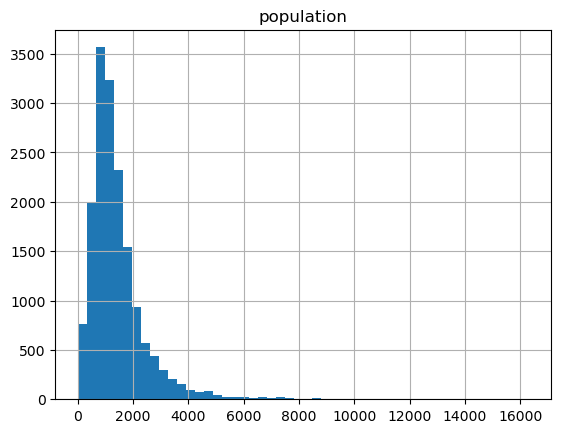

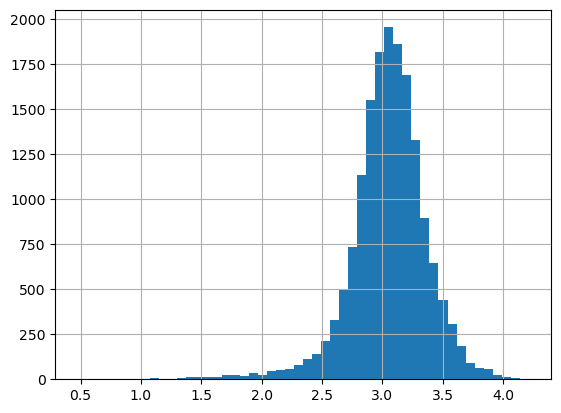

In [42]:
housing[['population']].hist(bins=50)
plt.show()

np.log10(housing['population']).hist(bins=50)
plt.show()

So far we’ve only looked at the input features, but the target values may
also need to be transformed. For example, if the target distribution has a
heavy tail, you may choose to replace the target with its logarithm. But if
you do, the regression model will now predict the log of the median house
value, not the median house value itself. You will need to compute the
exponential of the model’s prediction if you want the predicted median
house value.

Luckily, most of Scikit-Learn’s transformers have an
`inverse_transform()` method, making it easy to compute the inverse
of their transformations. 

For example, the following code example shows
how to scale the labels using a StandardScaler (just like we did for
inputs), then train a simple linear regression model on the resulting scaled
labels and use it to make predictions on some new data, which we
transform back to the original scale using the trained scaler’s
`inverse_transform()` method. 

Note that we convert the labels from a
Pandas Series to a DataFrame, since the `StandardScaler` expects 2D
inputs. Also, in this example we just train the model on a single raw input
feature (median income), for simplicity:

In [43]:
from sklearn.linear_model import LinearRegression


housing_labels = strat_train_set["median_house_value"].copy()

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)

some_new_data = housing[["median_income"]].iloc[:5] # pretend this is new data
scaled_predictions = model.predict(some_new_data)

predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

This works fine, but a simpler option is to use a
`TransformedTargetRegressor`. We just need to construct it, giving it
the regression model and the label transformer, then fit it on the training
set, using the original unscaled labels. It will automatically use the
transformer to scale the labels and train the regression model on the
resulting scaled labels, just like we did previously. Then, when we want to
make a prediction, it will call the regression model’s `predict()` method
and use the scaler’s `inverse_transform()` method to produce the
prediction:

In [44]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)

predictions = model.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

# Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to
write your own for tasks such as custom transformations, cleanup
operations, or combining specific attributes. 

For transformations that don’t require any training, you can just write a
function that takes a NumPy array as input and outputs the transformed
array. For example, as discussed in the previous section, it’s often a good
idea to transform features with heavy-tailed distributions by replacing them
with their logarithm (assuming the feature is positive and the tail is on the
right). Let’s create a log-transformer and apply it to the population
feature:

In [45]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out="one-to-one") 
# If it is ‘one-to-one’, then the output feature names will be equal to the input feature names.

log_pop = log_transformer.transform(housing[["population"]])

log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


The `inverse_func` argument is optional. It lets you specify an inverse
transform function, e.g., if you plan to use your transformer in a
`TransformedTargetRegressor`.

# Transformation Pipelines

As you can see, there are many data transformation steps that need to be
executed in the right order. Fortunately, Scikit-Learn provides the
Pipeline class to help with such sequences of transformations. Here is
a small pipeline for numerical attributes, which will first impute then scale
the input features:

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
    ])

num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

The Pipeline constructor takes a list of name/estimator pairs (2-tuples)
defining a sequence of steps. The
estimators must all be transformers (i.e., they must have a
`fit_transform()` method), except for the last one, which can be
anything: a transformer, a predictor, or any other type of estimator.

If you don’t want to name the transformers, you can use the
`make_pipeline()` function instead; it takes transformers as
arguments and creates a Pipeline using the names of the transformers’
classes, in lowercase and without underscores (e.g.,
"`simpleimputer`"):

In [47]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [48]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


When you call the pipeline’s `fit()` method, it calls `fit_transform()`
sequentially on all the transformers, passing the output of each call as the
parameter to the next call until it reaches the final estimator, for which it
just calls the `fit()` method.

The pipeline exposes the same methods as the final estimator. In this
example the last estimator is a `StandardScaler`, which is a transformer,
so the pipeline also acts like a transformer. 

If you call the pipeline’s `transform()` method, it will sequentially apply all the transformations to the data. If the last estimator were a predictor instead of a transformer, then the pipeline would have a `predict()` method rather than a `transform()` method. Calling it would sequentially apply all the
transformations to the data and pass the result to the predictor’s
`predict()` method.

In [49]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.13746004,
         1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, ..., -0.69377062,
        -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, ..., -0.78876841,
        -0.77572662, -0.75978881],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  1.26829911,
         0.67913534,  0.1010487 ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.27356264,
         0.88286825,  0.14539615],
       [-1.41803793,  0.94797769,  1.22545939, ..., -0.67915557,
        -0.75221898, -0.31034135]])

If you want to recover a nice DataFrame, you can use the pipeline’s get_feature_names_out() method:

In [50]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared,
                                       columns=num_pipeline.get_feature_names_out())
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
1,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
2,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
3,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
4,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
16507,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
16508,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
16509,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
16510,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


So far, we have handled the categorical columns and the numerical
columns separately. It would be more convenient to have a single
transformer capable of handling all columns, applying the appropriate
transformations to each column. For this, you can use a
`ColumnTransformer`. For example, the following `ColumnTransformer`
will apply `num_pipeline` (the one we just defined) to the numerical
attributes and `cat_pipeline` to the categorical attribute:

In [51]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", 
               "housing_median_age", 
               "total_rooms",
               "total_bedrooms", 
               "population", 
               "households",
               "median_income"]

cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)])

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['ocean_proximity'])])

If we didn't have `ColumnTransformer`, we would use `num_pipeline` on housing, which would return an array of standardized numerical columns only. Then, we would apply `cat_pipeline` on housing, and this would return a one-hot-encoded ocean_proximity array. Finally, we would need to combine these two arrays manually. `ColumnTransformer` saves us from the need to manually merge these arrays. 

The `ColumnTransformer` will utilize the attribute lists associated with each pipeline to create separate dataframes from the input dataframe. 
Subsequently, it will provide these dataframes as input to the corresponding pipelines.

In [52]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

In [53]:
df_housing_prepared = pd.DataFrame(housing_prepared,
                                   columns=preprocessing.get_feature_names_out())
df_housing_prepared

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
0,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
1,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
2,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
3,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
4,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041,1.0,0.0,0.0,0.0,0.0
16508,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630,0.0,1.0,0.0,0.0,0.0
16509,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049,0.0,0.0,0.0,0.0,1.0
16510,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396,1.0,0.0,0.0,0.0,0.0


Your project is going really well and you’re almost ready to train some
models! You now want to create a single pipeline that will perform all the
transformations you’ve experimented with up to now. Let’s recap what the
pipeline will do and why:

* Missing values in numerical features will be imputed by replacing
them with the median, as most ML algorithms don’t expect missing
values. In categorical features, missing values will be replaced by the
most frequent category.

* The categorical feature will be one-hot encoded, as most ML
algorithms only accept numerical inputs.

* A few ratio features will be computed and added: `bedrooms_ratio`,
`rooms_per_house`, and `people_per_house`. Hopefully these will
better correlate with the median house value, and thereby help the
ML models.

* Features with a long tail will be replaced by their logarithm, as most
models prefer features with roughly uniform or Gaussian distributions.

* All numerical features will be standardized, as most ML algorithms
prefer when all features have roughly the same scale.

The code that builds the pipeline to do all of this should look familiar to you
by now:

In [54]:
# SimpleImputer and StandardScaler take a pandas object and 
# return an numpy array without column names. 
# If you want the column names, you call their get_feature_names_out(). 
# FunctionTransformer, on the other hand, if it gets a pandas object, 
# it returns again a pandas, so names are preserved. However, it doesn't
# have a get_feature_names_out() by default. 
# In order to make it similar to SimpleImputer and StandardScaler, 
# we should provide a feature_names_out function. 
# This enables Pipeline to construct the output feature names for complex pipelines.
# See documentation. 

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.get_feature_names_out
# The feature_names_out function should return a list of strings. 
# It takes two arguments: function_transformer and feature_names_in.
# The function_transformer is the FunctionTransformer object itself,
# and feature_names_in is the list of input feature names.
# In our case, we want to return a list with one string, "ratio".
# So, we can use lambda function to do that.
# The lambda function in our case does not need the feature_names_in argument 
# because it only returns a list with one string. Still, we need to provide it.

# Now let's discuss the func argument.
# The func argument is the function that will be applied to the input data.
# In our case, we want to divide the first column by the second column.
# So, we can use a simple lambda function to do that.
# The lambda function in our case requires the input data, X,
# and returns a two dimensional numpy array with one column.
# X[:, [0]] is the first column of the input data.
# X[:, [1]] is the second column of the input data.
# We divide the first column by the second column.
# We retain the two dimensional structure by using double brackets.
# Were we to use single brackets, we would get a one dimensional array.
# By using double brackets, we get a two dimensional array with one column.

ratio_pipeline = make_pipeline(
      SimpleImputer(strategy="median"), 
      FunctionTransformer(func=lambda X: X[:, [0]] / X[:, [1]], 
                          feature_names_out=lambda function_transformer, feature_names_in: ["ratio"]), 
      StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())


# The `ColumnTransformer` will utilize the attribute lists associated with 
# each pipeline to create separate dataframes from the input dataframe. 
# Subsequently, it will provide these dataframes as input to the corresponding pipelines.

preprocessing = ColumnTransformer(
    [("bedrooms_per_rooms", ratio_pipeline, ["total_bedrooms","total_rooms"]),
     ("rooms_per_house", ratio_pipeline, ["total_rooms","households"]),
     ("people_per_house", ratio_pipeline, ["population","households"]),
     ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                            "households", "median_income"]),
     ("cat", cat_pipeline, ["ocean_proximity"])], 
     
     remainder=default_num_pipeline
)

housing_prepared = preprocessing.fit_transform(housing)

print(housing_prepared.shape)
print(preprocessing.get_feature_names_out())

(16512, 16)
['bedrooms_per_rooms__ratio' 'rooms_per_house__ratio'
 'people_per_house__ratio' 'log__total_bedrooms' 'log__total_rooms'
 'log__population' 'log__households' 'log__median_income'
 'cat__ocean_proximity_<1H OCEAN' 'cat__ocean_proximity_INLAND'
 'cat__ocean_proximity_ISLAND' 'cat__ocean_proximity_NEAR BAY'
 'cat__ocean_proximity_NEAR OCEAN' 'remainder__longitude'
 'remainder__latitude' 'remainder__housing_median_age']


Let's see how naming of features is done in the result. 

The names of features are constructed as `<name of transformer>__<name of feature>`.

In `bedrooms_per_rooms__ratio`:

* `bedrooms_per_rooms` is the name of the pipeline that created this feature. The pipeline is instantiated to `ratio_pipeline`.
* `ratio` is the name of the feature that the `ratio_name()` function created. 

In `log__population`:

* `log` is the name of the pipeline that created this feature. The pipeline is instantiated to `log_pipeline`.
* `population` is the name of the feature that `FunctionTransformer(np.log, feature_names_out="one-to-one")` --used in the `log_pipeline`-- creates if a dataframe with a `population` column is provided. This is because we have specified `feature_names_out="one-to-one"`, which means the output feature will have the same name as the input feature. 


In `cat__ocean_proximity_INLAND`:

* `cat` is the name of the pipeline that created this feature. The pipeline is instantiated to `cat_pipeline`. 
* `ocean_proximity_INLAND` is the name of the feature that `OneHotEncoder` --used in the `cat_pipeline`-- creates if a dataframe with a `ocean_proximity` column that contains a value `INLAND` is provided.


In `remainder__longitude`:

* `remainder` is the name of the pipeline that created this feature. The last line in our `ColumnTransformer` creates a pipeline called `remainder` which is instantiated to `default_num_pipeline`.  
* `longitude` is the name of the feature that `SimpleImputer` and `StandardScaler` --used in the pipeline-- creates. These transformers are set to `feature_names_out="one-to-one"` internally. 

# Select and Train a Model

At last! You framed the problem, you got the data and explored it, you
sampled a training set and a test set, and you wrote a preprocessing
pipeline to automatically clean up and prepare your data for machine
learning algorithms. You are now ready to select and train a machine
learning model.

## Train and Evaluate on the Training Set

The good news is that thanks to all these previous steps, things are now
going to be easy! You decide to train a very basic linear regression model
to get started:

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

# housing_labels is the column we want to predict
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_per_rooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function <lambda...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('linearregression', LinearRegression())])

Done! You now have a working linear regression model. You try it out on
the training set, looking at the first five predictions and comparing them to
the labels:

In [56]:
housing_predictions = lin_reg.predict(housing)
housing_predictions

array([260051.36004114, 357897.79846769, 125817.08984353, ...,
       209311.19783036, 295827.28647046, 256921.22105069])

Well, it works, but not well: the first prediction is way off (by over
$200,000!). Remember that you chose to use
the RMSE as your performance measure, so you want to measure this
regression model’s RMSE on the whole training set using Scikit-Learn’s
mean_squared_error() function, with the squared argument set to
False:

In [57]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

70630.22169174394

This is better than nothing, but clearly not a great score: the
median_housing_values of most districts range between \$120,000
and \$265,000, so a typical prediction error of \$70,630 is really not very
satisfying. This is an example of a model underfitting the training data.
When this happens it can mean that the features do not provide enough
information to make good predictions, or that the model is not powerful
enough. As we saw in the previous chapter, the main ways to fix
underfitting are to select a more powerful model, to feed the training
algorithm with better features, or to reduce the constraints on the model.
This model is not regularized, which rules out the last option. You could try
to add more features, but first you want to try a more complex model to
see how it does.

You decide to try a `DecisionTreeRegressor`, as this is a fairly powerful
model capable of finding complex nonlinear relationships in the data
(decision trees are presented in more detail in Chapter 6):

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())

tree_reg.fit(housing, housing_labels)

housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels,housing_predictions,squared=False)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect?
Of course, it is much more likely that the model has badly overfit the data.
How can you be sure? As you saw earlier, you don’t want to touch the test
set until you are ready to launch a model you are confident about, so you
need to use part of the training set for training and part of it for model
validation.

# Better Evaluation Using Cross-Validation

One way to evaluate the decision tree model would be to use the 
`train_test_split()` function to split the training set into a smaller training set
and a validation set, then train your models against the smaller training set
and evaluate them against the validation set. It’s a bit of effort, but nothing
too difficult, and it would work fairly well.
A great alternative is to use Scikit-Learn’s k_-fold cross-validation feature.
The following code randomly splits the training set into 10 nonoverlapping
subsets called folds, then it trains and evaluates the decision tree model
10 times, picking a different fold for evaluation every time and using the
other 9 folds for training. The result is an array containing the 10
evaluation scores:

In [59]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, 
                              housing,housing_labels,
                              scoring="neg_root_mean_squared_error", 
                              cv=10)
tree_rmses

array([68311.72448315, 66468.45825028, 68878.97215674, 72487.88076681,
       68071.80198498, 68941.6253554 , 71231.63026788, 71901.47344881,
       71114.92000388, 70089.62180378])

**Warning**. Scikit-Learn’s cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the RMSE. It’s a negative value, so you need to switch the sign of the output to get the RMSE scores.

In [60]:
np.mean(tree_rmses)

69749.81085217197

Now the decision tree doesn’t look as good as it did earlier. In fact, it
seems to perform almost as poorly as the linear regression model!